## Setup

In [ ]:
!nvidia-smi

Wed Jul  6 16:30:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.autograd import Variable 

#!pip install pandas==1.3.0 #1.3.0
import pandas as pd

import glob
!pip3 install pickle5
import pickle5 as pickle
import os

from torch.utils.data import Dataset, DataLoader, random_split, Subset, RandomSampler
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, confusion_matrix
#from pandas.core.computation.check import NUMEXPR_INSTALLED

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.1 MB/s 


### Five Key Steps
#### 1. Load and normalize the train and test data 
#### 2.Define the Convolutional Neural Network (CNN)
#### 3. Define the loss function and optimizer
#### 4. Train the model on the train data
#### 5. Test the model on the test data

In [ ]:
#Mount Drive to get data
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#set the device to cuda:0 
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

## Dataset

In [ ]:
#Load In the Dataset
class EEGDataset(Dataset):

  def __init__(self, data_path, chunk_size=1000):
    """
        Args:
            data_path (string): Directory with the EEG training data. Filenames in this dir must begin with "PD" or "Control" to assign labels correctly. Must be in .csv files. 
            chunk_size (int): Number of datapoints from EEG time series to be included in a single non-overlapping epoch. Note that UNM data was collected at 500Hz.
    """

    #create a list of datafields to keep. The electrodes given here are those in common to both the UI and UNM datasets.
    self.common_electrodes = ['time', 'Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'POz', 'PO8', 'P6', 'P2', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8']

    #create the datapaths
    self.data_path = data_path  
    self.data_list = glob.glob(self.data_path + "*.csv")

    #create containers for the data and labels respectively
    self.df_list = []
    self.label_list = []

    self.files = glob.glob(self.data_path+ '*.csv')

    for file in self.files:

      if os.path.isfile(file):
        csv = pd.read_csv(file,sep=',', index_col=[0]) #load in single session as a csv
        csv = csv.drop(index=0, inplace=False, axis=0) #drop first row because it's usually noisy
        csv = csv[self.common_electrodes]             #select the subset of electrodes defined by self.common_electrodes
        csv = csv.drop('time', inplace=False, axis=1) #drop time so it is not considered as a variable

        #csv is then segmented into epochs. Each epochs is added as a df to the list of data with a corresponding list of labels (at this point the whole filename is given as the label).
        for chunk in range(1,csv.shape[0]//chunk_size +1):
            start = (chunk-1)*chunk_size
            stop = chunk*chunk_size
            self.df_list.append(csv.iloc[start:stop])
            self.label_list.append(file)

    print('there are this many items in the list of data ' ,len(self.df_list))  
    print('there are this many items in the list of labels ' , len(self.label_list))

    #define the labels as vectors to match training
    self.class_map = {"CTL" : [0, 1], "PD": [1, 0]} 
    
    #Normalize each channel of each epoch to a mean of 0 and std of 1.
    self.all_data = self.df_list[0]
    
    self.normalized_df_list = []
    
    #iterate through each epoch
    for df_index in range(0,len(self.df_list)):
      
      temp_df = self.df_list[df_index]
      mean_by_channel = []
      std_by_channel = []
      
      #determine normalization parameters by column (i.e. for each channel)
      for column in temp_df:
        mean_by_channel.append(temp_df[column].mean())
        std_by_channel.append(temp_df[column].std())

      #apply normalization
      temp_df = temp_df.sub(mean_by_channel, axis='columns')
      temp_df = temp_df.div(std_by_channel, axis='columns')
      self.normalized_df_list.append(temp_df)

    assert (len(std_by_channel)== len(mean_by_channel)), 'length of mean normalization and std normalization are not same length'
    print('The length of the lists of channels means and stds is ', len(mean_by_channel))
    assert ((self.normalized_df_list[0].shape)==(self.df_list[0].shape) and (len(self.normalized_df_list)==len(self.df_list))), 'Normalization changed the shape of the df_list'
      

  #this is a required function that tells you how many data points you have in the dataset
  def __len__(self):
      return len(self.normalized_df_list) 

  #this is a required function that allows you to obtain a single data point according to its index
  def __getitem__(self, idx):
    
    #each dataframe represents one block id
    eeg_dataframe = self.normalized_df_list[idx]
    
    #determine whether that subject is control or PD
    filename = self.label_list[idx].split('/')[-1]
    # this is the string containing the filename. index first 2 chars to see if PD.
    if filename[0:2]=='PD':
      PD_label = 'PD'
    # then see if its control
    elif filename[0:7]=='Control':
      PD_label = 'CTL'
    # if neither, throw an error
    else:
      print(self.label_list[idx][0:2])
      print(self.label_list[idx][0:7])
      assert False, 'there is a problem finding the label'

    #convert label to tensor using class map
    PD_label = torch.tensor(self.class_map[PD_label], dtype=torch.long)
    
    #reformat the eeg data
    eeg_tensor = torch.tensor(eeg_dataframe[0:chunk_size].values) #you can artificially shorten epochs here
    eeg_tensor = torch.permute(eeg_tensor,(1, 0))
    
    return eeg_tensor.float(), PD_label.float(), filename


## Define the Neural Network

In [ ]:
class PDNet(nn.Module):

    def __init__(self,chunk_size=2500):
        super(PDNet, self).__init__()
        self.chunk_size = chunk_size

        self.conv1 = nn.Conv1d(in_channels=60, out_channels=21, kernel_size=20,stride=1)
        self.norm1 = nn.BatchNorm1d(num_features=21)
        self.maxpool1 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv2 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=10,stride=1)
        self.norm2 = nn.BatchNorm1d(num_features=42)
        self.maxpool2 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv3 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=10,stride=1)
        self.norm3 = nn.BatchNorm1d(num_features=42)
        self.maxpool3 = nn.MaxPool1d(kernel_size=4,stride=4)

        self.conv4 = nn.Conv1d(in_channels=42, out_channels=64, kernel_size=5,stride=1)
        self.norm4 = nn.BatchNorm1d(num_features=64)
        self.maxpool4 = nn.MaxPool1d(kernel_size=4,stride=4)

        
        self.relu = nn.LeakyReLU(0.1)

        
        self.fc1 = nn.Linear(in_features=448,out_features=256)#in_features=4*(self.chunk_size-8)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=64, out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.relu(self.maxpool1(self.norm1(self.conv1(x))))

        x = self.relu(self.maxpool2(self.norm2(self.conv2(x))))
        
        x = self.relu(self.maxpool3(self.norm3(self.conv3(x))))
        
        x = self.relu(self.maxpool4(self.norm4(self.conv4(x))))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimensi
        
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.fc3(x)

        x = self.softmax(self.fc4(x))
        return x


In [ ]:
#test the input and output shapes
input_tensor = torch.rand([8,60,2500]).cuda() #of the form [batch_size, channels, epoch_length]
print(input_tensor.size())
park_net = PDNet().cuda()
output_tensor = park_net(input_tensor)
print((output_tensor.shape))


torch.Size([8, 60, 2500])
torch.Size([8, 2])


## Test

In [ ]:
#testing the performance
def validate(model, valloader,threshold=0.5,batch_size=8, supress_output=False):
  '''
    INPUTS:
      model(nn.Module): here we will pass PDNet to the training loop. 
      valloader(Dataloader): here we will pass the torch.utils.dataloader.Dataloader containing all the validation batches. 
      threshold(float): give a threshold above which a classification will be binarized to PD and below to CTL
      batch_size(int): batch size of the valloader
      supress_output(bool): False to get output print statements
    
    OUTPUTS:
      true_positives, false_positives, true_negatives, false_negatives (int):confusion matrix
      vote (str): correct/incorrect
  '''

  total_loss = 0
  true_positives = 0
  true_negatives = 0
  false_positives = 0
  false_negatives = 0

  counter = 0

  #This loads a batch at time
  for i, data in enumerate(valloader, 0):
    #read in data
    inputs, labels, filename = data
    inputs, labels = torch.permute(inputs,(0,1,2)).to(device), labels.to(torch.float32).to(device) #send them to the GPU
    
    #forward
    output = model(inputs)

    #calculate loss using L2 regularization and CE loss
    criterion = nn.CrossEntropyLoss() 
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    total_loss += criterion(output,labels) + l2_lambda*l2_norm 
    counter += 1
  
    #binarize output according to the threshold you set
    output[output>threshold] = 1
    output[output<=threshold] = 0

    #determine whether each classification was true/false and postive/negative
    for j in range(0,len(output)):
      if (output[j-1,0] == 1) and (labels[j-1,0] == 1):
          true_positives += 1
      elif(output[j-1,0]==1) and (labels[j-1,0] == 0):
          false_positives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 1):
          false_negatives += 1
      elif(output[j-1,0]==0) and (labels[j-1,0]== 0):
          true_negatives += 1

  #aggregate epochs via majority vote
  if (true_positives + true_negatives) > (false_negatives + false_positives):
    vote = 'Correct'
  elif (true_positives + true_negatives) < (false_negatives + false_positives):
    vote = 'Incorrect'
  else:
    vote = 'Unsure'

  if supress_output == False:
    print('true positives: ', true_positives)
    print('false positives: ',false_positives)
    print('true negatives: ',true_negatives)
    print('false negatives', false_negatives)  
    print('The vote was: ', vote)

  return true_positives, false_positives, true_negatives, false_negatives, vote



## Load Data and Model

In [ ]:
# specify the filename of your pretrained model
experiment_name = 'UNM_training_demo'
#specify the folder location of your model 
model_folder = '/content/drive/MyDrive/'
PATH = model_folder + experiment_name

if (os.path.exists(PATH)):
  model = torch.load(PATH).to(device)
  print(' model has been successfully loaded')
  
else:
  print('model was not found')
  model = PDNet(chunk_size=chunk_size).to(device)
  log_containing_train_loss = []
  log_containing_val_loss = []
  print('new model has been successfully created')

 model has been successfully loaded


In [ ]:
#manual model loading
#model = torch.load( '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')

In [ ]:
#manual model saving
#torch.save(model, '/content/drive/MyDrive/UTOR-MSc/colab_notebooks/model_weights/external_validation_training')

## Subject Level Analysis

In [ ]:
################### create whole dataset to later be subsetted #################
batch_size = 8
num_workers = 2
chunk_size = 2500

#data locations for full train/val data
data_src = '/content/drive/MyDrive/Iowa_Data/' 

#load in the EEG data to the dataset class
EEG_whole_Dataset = EEGDataset(data_path=data_src,  chunk_size=chunk_size)

there are this many items in the list of data  1042
there are this many items in the list of labels  1042
The length of the lists of channels means and stds is  60


In [ ]:
############ create list of subject_numbers ###############################
files = glob.glob(data_src + '*.csv')
subject_list = []
filename_list = []
for file in files:  
  filename = file.split('/')[-1] #remove all preceeding directories
  
  filebasename = filename.split('.')[0] #drop the .csv
  
  subject_number = filebasename[-4:] #last four will be the subject number
  
  subject_list.append(subject_number)
  filename_list.append(filename)
  

In [ ]:
##################### TESTING ###########################################
'''
Here, a for loop will iterate through every object in the whole dataset. Using the filename, it will determine the
subject number for the sample and make a test set using only the one subject number. It will repeat this for each subject number.
Epochs and Learning rate are adjustable below.
'''
model.eval()
correct_votes, incorrect_votes, unsure_votes = 0,0,0
true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0
subject_TP, subject_FP, subject_TN, subject_FN = 0, 0, 0, 0
correct_epochs_list, incorrect_epochs_list = [], []

#leave_out will be 
for filename in filename_list:
  to_test = []
  print('Performing testing on subject number: ', filename.split('.')[0])

  for index in range(len(EEG_whole_Dataset)):
    
    complete_list = range(len(EEG_whole_Dataset))
    subset_ds = Subset(EEG_whole_Dataset, [index])
    sample_sampler = RandomSampler(subset_ds)
    subset_dataloader = DataLoader(subset_ds, sampler=sample_sampler, batch_size=1)
    data = next(iter(subset_dataloader))
    eeg_data, label, file = data
    
    if file[0] == filename:
      
      to_test.append(index)

  #to_be_kept = [x for x in complete_list if x not in to_be_removed]
  #train_dataset = Subset(EEG_whole_Dataset, to_be_kept)
  
  val_dataset = Subset(EEG_whole_Dataset, to_test)

  
  #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  
  del val_dataset # ,train_dataset


  TP, FP, TN, FN, vote = validate(model=model, valloader=val_dataloader,threshold=0.5,batch_size=8, supress_output=False)
  correct_epochs_list.append(TP+TN) 
  incorrect_epochs_list.append(FP+FN) 

  true_positives += TP
  false_positives += FP
  true_negatives += TN
  false_negatives += FN
  if vote == 'Correct':
    correct_votes += 1
    if TP >0:
      subject_TP += 1
    elif TN >0:
      subject_TN += 1
    
  elif vote == 'Incorrect':
    incorrect_votes += 1
    if FP >0:
      subject_FP += 1
    elif FN >0:
      subject_FN += 1
  else:
    unsure_votes +=1

  
  print('-----------------------------------------------------------------------')

print('total True Positives: ', true_positives)
print('total False Positives: ', false_positives)
print('total True Negatives: ', true_negatives)
print('total False Negatives: ', false_negatives)
print('total correct subject classifications: ', correct_votes)
print('total incorrect subject classifications: ', incorrect_votes)
print('total unsure subject classifications: ',unsure_votes)
print('total subject level True positives: ', subject_TP)
print('total subject level False Positives: ', subject_FP)
print('total subject level True Negatives: ', subject_TN)
print('total subject level False Negatives: ', subject_FN)
subject_accuracy = (subject_TP + subject_TN) / (subject_TP + subject_FP +subject_TN+subject_FN)
print('total subject accuracy: ')
subject_F1 = 2*subject_TP / (2*subject_TP + subject_FP + subject_FN)
print('total subject F1: ', subject_F1)
subject_sensitvity = subject_TP / (subject_TP + subject_FN)
print('total subject sensitivity: ',subject_sensitvity)
subject_specificity = subject_TN / (subject_FP + subject_TN)
print('total subject specificity: ', subject_specificity)

print('----------------------------------------------------------------')

Performing testing on subject number:  Control1041
true positives:  0
false positives:  1
true negatives:  42
false negatives 0
The vote was:  Correct
-----------------------------------------------------------------------
Performing testing on subject number:  Control1021
true positives:  0
false positives:  2
true negatives:  40
false negatives 0
The vote was:  Correct
-----------------------------------------------------------------------
Performing testing on subject number:  Control1061
true positives:  0
false positives:  15
true negatives:  27
false negatives 0
The vote was:  Correct
-----------------------------------------------------------------------
Performing testing on subject number:  Control1081
true positives:  0
false positives:  7
true negatives:  45
false negatives 0
The vote was:  Correct
-----------------------------------------------------------------------
Performing testing on subject number:  Control1101
true positives:  0
false positives:  36
true negatives: 

## Visualization

In [ ]:
def plot_roc_auc(specificities, sensitivities):
  plt.figure(figsize=(6,4))
  plt.plot((1-np.array(specificities)),sensitivities);
  #plt.title('ROC Curve', size= 20);
  plt.xlabel('1-Specificity', size = 14);
  plt.ylabel('Sensitivity', size = 14);
  plt.ylim(0,1)
  plt.legend(['CNN'])
  AUC = auc((1-np.array(specificities)),sensitivities)
  plt.text(0.7,0.2, 'AUC = %f'%AUC, fontsize=10)
  plt.show()


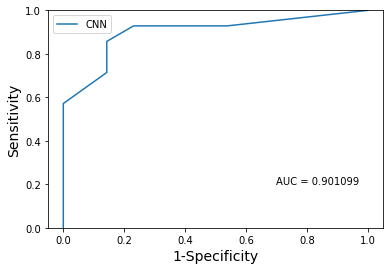

In [ ]:
plot_roc_auc(subject_specificities, subject_sensitvities)

In [ ]:
def plot_confusion_matrix(TP, FP, TN, FN):
  pred = []
  true = []

  for i in range(TP):
    pred.append(1)
    true.append(1)
  
  for i in range(FP):
    pred.append(1)
    true.append(0)
  
  for i in range(TN):
    pred.append(0)
    true.append(0)

  for i in range(FN):
    pred.append(0)
    true.append(1)

  plt.figure(figsize=(8,6))
  conf_matrix = (confusion_matrix(true, pred))
  # Using Seaborn heatmap to create the plot
  fx = sns.heatmap(conf_matrix,cmap='vlag',annot=True, annot_kws={'fontsize':15},fmt='g')
  
  # labels the title and x, y axis of plot
  #fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
  fx.set_xlabel('Predicted Values',size=16)
  fx.set_ylabel('Actual Values ', size=16);

  # labels the boxes
  fx.xaxis.set_ticklabels(['CTL','PD'],size=15)
  fx.yaxis.set_ticklabels(['CTL','PD'],size=15)

  plt.show()

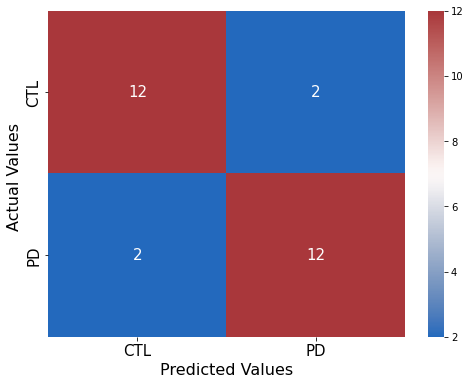

In [ ]:
#manual entry of confusion matrix
plot_confusion_matrix(TP=12, FP=2, TN=12, FN=2)